In [26]:
# Neighbors, UMAP, Leiden clustering & save outputs
import os
import scanpy as sc

# Reproducibility
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=120, frameon=False)
sc.settings.seed = 0

# Paths 
IN_H5AD = "../data/processed/SKCM_GSE134388_aPD1_norm_hvg_pca.h5ad"
OUT_H5AD = "../data/processed/SKCM_GSE134388_aPD1_umap.h5ad"

PLOT_DIR = "../results/umap"
os.makedirs(PLOT_DIR, exist_ok=True)

# Load AnnData
adata = sc.read_h5ad(IN_H5AD)
print("Loaded:", adata.shape)
print("obs columns sample:", list(adata.obs.columns)[:15])
print("var columns sample:", list(adata.var.columns)[:15])


Loaded: (3632, 2000)
obs columns sample: ['UMAP_1', 'UMAP_2', 'Cluster', 'Celltype (malignancy)', 'Celltype (major-lineage)', 'Celltype (minor-lineage)', 'Patient', 'Sample', 'Tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes']
var columns sample: ['mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std']


In [27]:
# Computing neighborhood graph (KNN graph) with Common defaults: n_neighbors=15, n_pcs=30 
n_neighbors = 15
n_pcs = 30

if "X_pca" not in adata.obsm:
    raise ValueError("PCA not found. Run Script 03 to compute PCA and save the .h5ad.")

n_pcs = min(n_pcs, adata.obsm["X_pca"].shape[1])
print("Using n_neighbors =", n_neighbors, "| n_pcs =", n_pcs)

sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

print("Neighbors computed.")
print("uns['neighbors'] keys:", adata.uns["neighbors"].keys())


Using n_neighbors = 15 | n_pcs = 30
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
Neighbors computed.
uns['neighbors'] keys: dict_keys(['connectivities_key', 'distances_key', 'params'])


computing UMAP
    finished (0:00:04)


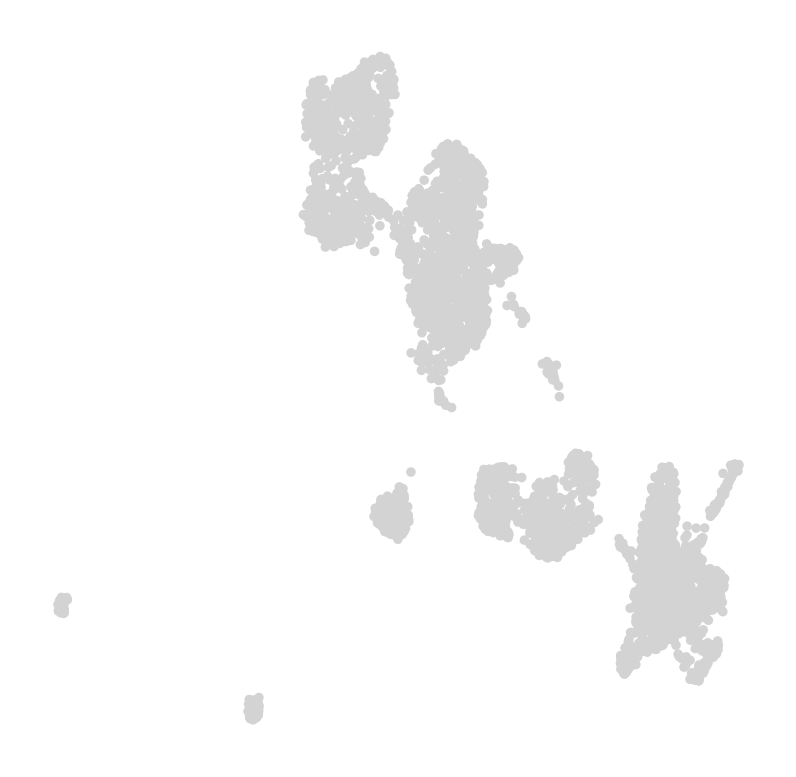

Saved: ../results/umap\umap_base.png


In [28]:
# UMAP
sc.tl.umap(adata)

# Basic UMAP plot (no colors)
sc.pl.umap(adata, show=True)

# Save a clean UMAP image
sc.pl.umap(adata, show=False)
import matplotlib.pyplot as plt
plt.savefig(os.path.join(PLOT_DIR, "umap_base.png"), bbox_inches="tight")
plt.close()
print("Saved:", os.path.join(PLOT_DIR, "umap_base.png"))


In [29]:
# Leiden clustering Resolution controls number of clusters. Start with 0.5, then try 0.8 / 1.0 if needed.
resolution = 0.5
sc.tl.leiden(adata, resolution=resolution, key_added="leiden")

print("Leiden clusters:", adata.obs["leiden"].value_counts().sort_index())


running Leiden clustering
    finished (0:00:00)
Leiden clusters: leiden
0     1034
1      922
2      466
3      342
4      308
5      186
6      123
7       63
8       61
9       45
10      31
11      30
12      21
Name: count, dtype: int64


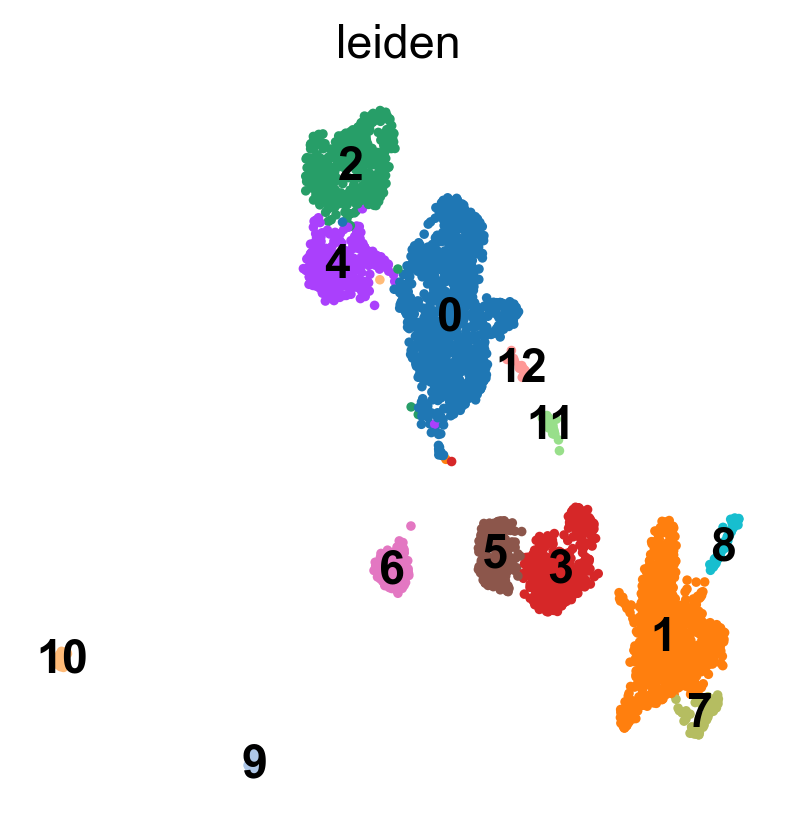

Saved: ../results/umap\umap_leiden_res0.5.png


In [30]:
# Plot UMAP colored by Leiden clusters
sc.pl.umap(adata, color=["leiden"], legend_loc="on data", show=True)


# Save UMAP Leiden plot
sc.pl.umap(adata, color=["leiden"], legend_loc="on data", show=False)
import matplotlib.pyplot as plt
plt.savefig(os.path.join(PLOT_DIR, f"umap_leiden_res{resolution}.png"), bbox_inches="tight")
plt.close()
print("Saved:", os.path.join(PLOT_DIR, f"umap_leiden_res{resolution}.png"))


QC cols found: ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']


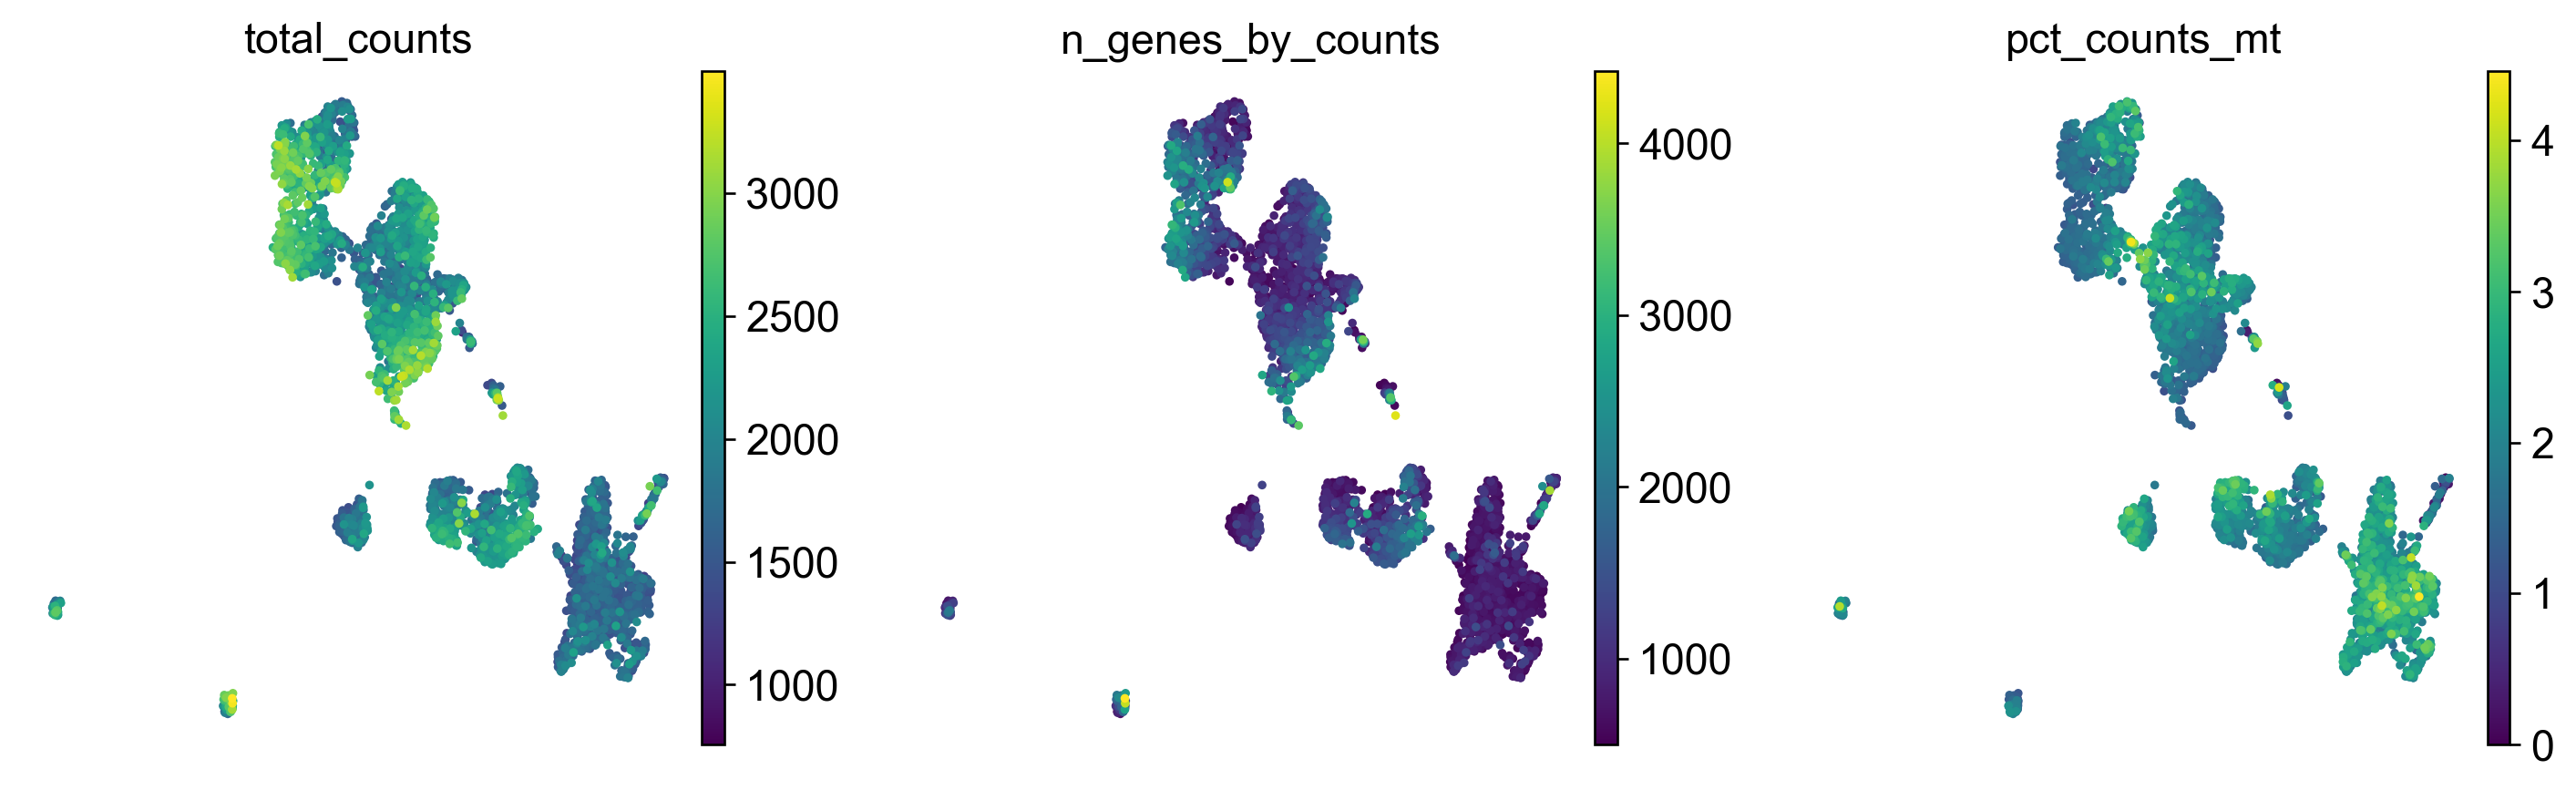

Saved: ../results/umap\umap_total_counts.png
Saved: ../results/umap\umap_n_genes_by_counts.png
Saved: ../results/umap\umap_pct_counts_mt.png


In [31]:
# UMAP colored by QC metrics 

qc_cols = [c for c in ["total_counts", "n_genes_by_counts", "pct_counts_mt"] if c in adata.obs.columns]
print("QC cols found:", qc_cols)

if qc_cols:
    sc.pl.umap(adata, color=qc_cols, show=True)


# Save QC-colored UMAPs
import matplotlib.pyplot as plt

for c in qc_cols:
    sc.pl.umap(adata, color=[c], show=False)
    out = os.path.join(PLOT_DIR, f"umap_{c}.png")
    plt.savefig(out, bbox_inches="tight")
    plt.close()
    print("Saved:", out)


In [32]:
# Save AnnData after neighbors/UMAP/clustering

adata.write(OUT_H5AD)
print("Saved:", OUT_H5AD)


Saved: ../data/processed/SKCM_GSE134388_aPD1_umap.h5ad


In [33]:
# Summary to confirm everything is present
print("obsm keys:", list(adata.obsm.keys()))
print("uns keys contains UMAP?", "umap" in adata.uns)
print("leiden in obs?", "leiden" in adata.obs.columns)

if "leiden" in adata.obs:
    print("Number of clusters:", adata.obs["leiden"].nunique())


obsm keys: ['X_pca', 'X_umap']
uns keys contains UMAP? True
leiden in obs? True
Number of clusters: 13
